In [1]:
# this model includes ql
# it uses instantaneous bedrock erosion rate to calc ql
# it uses gamma to represent fraction of plucked material that becomes coarse gravel
# it uses theta to represent fraction of hillslope material that enters fluvial system as coarse 
## (maybe this should be same as gamma, 
## since the real fxn of this parameter is to tell us 
## how much coarse stuff is available for bedload transport/abrasion)

# potential updates: see if adding weighted average back in to ql calculation still allows for stability
## update on the update: this led to stability issues, and it's not worth the time now trying to debug, 
## so just stick with using instantaneous erosion rate. 
## Most interested in steady state profiles anyway, so this is fine.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# create a profile
dx = 500
x = np.arange(0, 50000, dx)
x_node = x + (dx/2)

# add some elevation
Hstar = 0.5 # depth decay
etab = np.zeros(len(x)) # bedrock elevation
etab[:] = np.linspace(1, 0.1, len(x)) # need to start with slight bedrock slope
H = Hstar + np.zeros(len(x)) # alluvium thickness
eta = etab + H # topography

In [4]:
# define constants and other parameters
K = 1e-6 # erodibility
beta = 0.0005 # abradability
r = 5. # runoff rate
U = 0.0001 # uplift or baselevel fall rate
I = 0.01 # intermittency
phi = 0.1 # porosity
D = 0.01 # grain size
gamma = 0.25 # fraction plucked that becomes coarse

kqs = 0.041 # sed transport coeff
kxb = 25 # valley width coeff
Pxb = 1./5. # valley width exp
kb = 8.3e-8 # channel width coeff

B_valley = kxb * (x_node**Pxb) # valley width
# Q = (r * kxb * x_node**(1 + Pxb))/(1 + Pxb) # discharge
A = (1./3.) * (x**2)
Q = r * A

In [5]:
def model(x, dx, x_node,
          K, beta, gamma,
          D, phi, Hstar,
          kb, kqs, I, r, U,
          etab, H, eta,
          B_valley, Q,
          num_steps = 1):
    
    q = Q/B_valley
    dt = 50
    
    run_duration = dt * num_steps
    cum_time = 0.0
    
    Qs = np.zeros(len(x))
    qs = np.zeros(len(x))
    Eb_p = np.zeros(len(x))
    Eb_a = np.zeros(len(x))
    Eb = np.zeros(len(x))
    Eh = np.zeros(len(x))
    E = np.zeros(len(x))
    ql = np.zeros(len(x)) # lateral sediment supply
    
    H[-1] = 0
    E[-1] = U
    q[0] = 0
    Qs[0] = 0
    
    while cum_time < run_duration:
        
        # drop baselevel
        eta[-1] -= U * dt
        
        # set boundary conditions
        etab[-1] = eta[-1]
        
        # calc slope
        S = -np.diff(eta)/dx
        
        # calc bed exposure
        alpha = np.exp(-H/Hstar)
        
        # calc sed transport
        Qs[1:] = kqs * I * Q[1:] * S**(7./6.) * (1 - alpha[:-1])
        qs[1:] = Qs[1:] / B_valley[1:]
        
        # calc bedrock erosion
        Eb_p[:-1] = K * Q[1:] * S**(7./6.) * alpha[:-1] * I
        Eb_a[:-1] = beta * Qs[1:] * alpha[:-1]
        Eb[:-1] = (Eb_p[:-1] + Eb_a[:-1]) / B_valley[:-1]
        
        # calc lateral flux
        ql[:-1] = ((Eb[:-1] * gamma)/beta) * (1 - np.exp(-beta * x[1:]/3))
        
        # calc grain attrition
        atr = Qs * beta
        
        # calc sediment erosion rate
        Eh[:-1] = 1/((1 - phi) * B_valley[:-1]) * (np.diff(Qs)/dx + atr[1:] - (Eb_p[:-1]*gamma) - ql[:-1])
        
        # calc total erosion rate
        E[:-1] = Eb[:-1] + Eh[:-1]
        
        # update topography
        etab[:-1] -= Eb[:-1] * dt
        H[:-1] -= Eh[:-1] * dt
        H[H<0] = 0
        eta[:-1] = etab[:-1] + H[:-1]
        
        # update elapsed time
        cum_time += dt
        
    print(cum_time)
        
    return (dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta)

In [6]:
#now write a test
num_steps = 2500000

test_run = [x, dx, x_node, 
            K, beta, gamma,
            D, phi, Hstar,
            kb, kqs, I, r, U,
            etab, H, eta,
            B_valley, Q,
            num_steps]

# and run it
(dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta) = model(*test_run)

125000000.0


In [7]:
Eb

array([9.99999999e-05, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
      

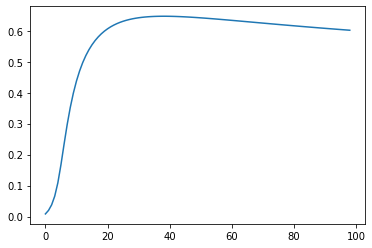

In [8]:
plt.plot(1-alpha[:-1])

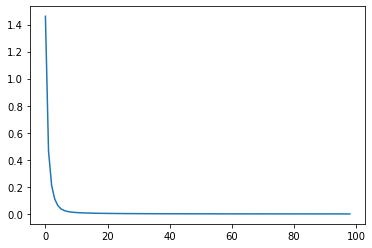

In [9]:
plt.plot(S)

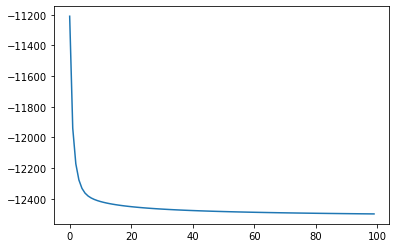

In [10]:
plt.plot(eta)

In [11]:
S[-1]

0.0003728565513119975

In [12]:
eta

array([-11209.22957932, -11939.84452045, -12172.28959636, -12277.66691441,
       -12332.61053983, -12363.6382728 , -12382.63804633, -12395.45568126,
       -12404.91139533, -12412.36662385, -12418.5201441 , -12423.76214432,
       -12428.32859013, -12432.37215486, -12435.99725416, -12439.2786113 ,
       -12442.27172792, -12445.01911586, -12447.55418145, -12449.903745  ,
       -12452.08973253, -12454.13034658, -12456.04089833, -12457.83441323,
       -12459.52208109, -12461.11359693, -12462.61742353, -12464.04099674,
       -12465.3908883 , -12466.67293644, -12467.89235201, -12469.05380544,
       -12470.16149879, -12471.21922578, -12472.23042243, -12473.19820982,
       -12474.12543063, -12475.01468048, -12475.86833488, -12476.68857262,
       -12477.47739618, -12478.23664949, -12478.96803358, -12479.67312031,
       -12480.35336456, -12481.01011499, -12481.64462366, -12482.25805454,
       -12482.85149122, -12483.42594368, -12483.9823545 , -12484.5216044 ,
       -12485.04451721, -

In [13]:
eta_adj = eta - eta[-1]

In [14]:
eta_adj

array([1.29017042e+03, 5.59555479e+02, 3.27110403e+02, 2.21733085e+02,
       1.66789460e+02, 1.35761727e+02, 1.16761953e+02, 1.03944318e+02,
       9.44886041e+01, 8.70333756e+01, 8.08798554e+01, 7.56378552e+01,
       7.10714093e+01, 6.70278446e+01, 6.34027453e+01, 6.01213882e+01,
       5.71282715e+01, 5.43808836e+01, 5.18458180e+01, 4.94962545e+01,
       4.73102669e+01, 4.52696529e+01, 4.33591011e+01, 4.15655862e+01,
       3.98779184e+01, 3.82864025e+01, 3.67825759e+01, 3.53590027e+01,
       3.40091112e+01, 3.27270630e+01, 3.15076475e+01, 3.03461940e+01,
       2.92385007e+01, 2.81807737e+01, 2.71695770e+01, 2.62017897e+01,
       2.52745688e+01, 2.43853190e+01, 2.35316646e+01, 2.27114268e+01,
       2.19226033e+01, 2.11633500e+01, 2.04319659e+01, 1.97268792e+01,
       1.90466349e+01, 1.83898845e+01, 1.77553758e+01, 1.71419449e+01,
       1.65485082e+01, 1.59740558e+01, 1.54176450e+01, 1.48783951e+01,
       1.43554823e+01, 1.38481350e+01, 1.33556302e+01, 1.28772890e+01,
      

In [15]:
# save csv files

np.savetxt('elevation csv files/eta_exp_13.csv', eta_adj, delimiter = ',')
np.savetxt('alpha csv files/alpha_exp_13.csv', alpha, delimiter = ',')
np.savetxt('slope csv files/slope_exp_13.csv', S, delimiter = ',')